In [1]:
from libs.data_manipulation import *
from libs.dim_reduction import *
from libs.feature_generation import *
from libs.clustering import *
from libs.convex_hull import *
from libs.alpha_shape import *

from mplsoccer import Pitch
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch

from matplotlib.patches import Polygon


In [2]:
df = compile_team_tracking_data("data/H_EURO2024GERMANY", "Denmark")
df = extract_one_match(df,1)


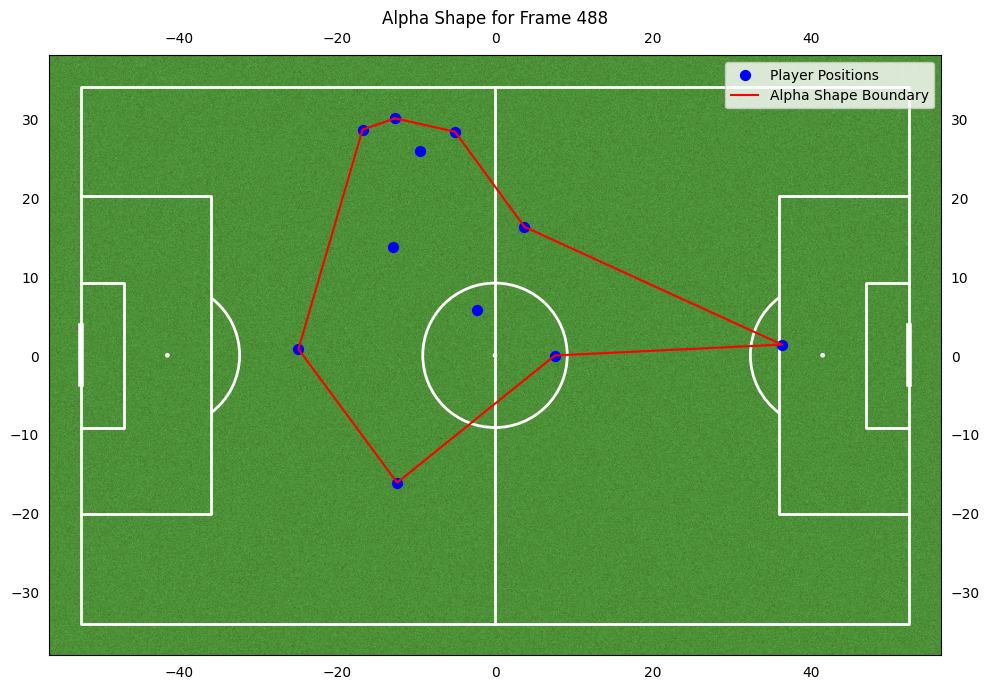

In [3]:
# Now run the alpha shape function with a smaller alpha value
alpha_shapes, frame_indices = alpha_shape(df.iloc[::48], "^home", num_players=11, alpha=0.05)

# Plot the alpha shape for a specific frame
frame_idx = 488

# Create a plot with the pitch
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# Scatter the player points for that frame
players = df.iloc[frame_indices[frame_idx]].filter(regex="^home").dropna().values.reshape(-1, 2)
ax.scatter(players[:, 0], players[:, 1], color='blue', s=50, label="Player Positions")

alpha_shape_polygon = alpha_shapes[frame_idx]

x, y = alpha_shape_polygon.exterior.xy
ax.plot(x, y, color='red', label="Alpha Shape Boundary")


plt.legend()
plt.title(f"Alpha Shape for Frame {frame_idx}")
plt.show()


In [5]:


def convex_hull(df: pd.DataFrame, regex: str = "^home", num_players: int = None):
    """
    Computes convex hulls for player positions, allowing the selection of a subset of players.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing player positions.
    regex (str): A regex pattern to filter player positions in the DataFrame.
    num_players (int): The number of players to include in the convex hull (optional).
    
    Returns:
    list: A list of ConvexHull objects for each frame of data.
    """
    # Filter columns based on the regex
    df = df.filter(regex=regex)
    np_data = df.to_numpy()  # Convert the DataFrame to a NumPy array
    points = []

    # Process each frame of data to extract player positions
    for row in np_data:
        row = row[~np.isnan(row)]  # Remove NaN values (incomplete player positions)
        player_positions = list(zip(row[0::2], row[1::2]))  # Create (x, y) pairs

        # If num_players is specified, limit the number of players
        if num_players is not None and len(player_positions) > num_players:
            # Sort players by their distance to the center of the field (or other criteria)
            center = np.mean(player_positions, axis=0)  # Calculate the central point (e.g., mean position)
            player_positions = sorted(player_positions, key=lambda pos: np.linalg.norm(np.array(pos) - center))
            player_positions = player_positions[:num_players]  # Select the top N closest players

        points.append(player_positions)

    # Compute convex hulls for each frame
    hulls = []
    for data in points:
        if len(data) >= 3:  # Convex hull requires at least 3 points
            hulls.append(ConvexHull(data))

    return hulls, df.index.to_numpy()

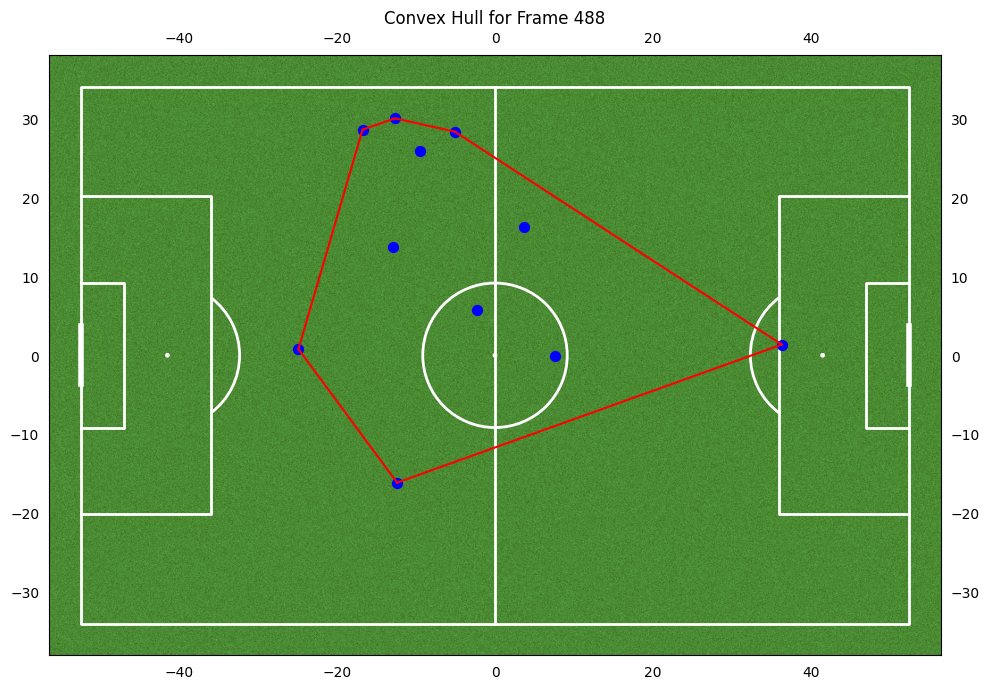

: 

In [ ]:
# Convex hull
hulls, frame_indices = convex_hull(df.iloc[::48], "^home", num_players=11)

# Plot the convex hull for a specific frame
frame_idx = 488

# Create a plot with the pitch
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# Scatter the player points for that frame
players = df.iloc[frame_indices[frame_idx]].filter(regex="^home").dropna().values.reshape(-1, 2)
ax.scatter(players[:, 0], players[:, 1], color='blue', s=50, label="Player Positions")

hull = hulls[frame_idx]
for simplex in hull.simplices:
    ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r-')  # Draws lines between points of each simplex

plt.title(f"Convex Hull for Frame {frame_idx}")
plt.show()


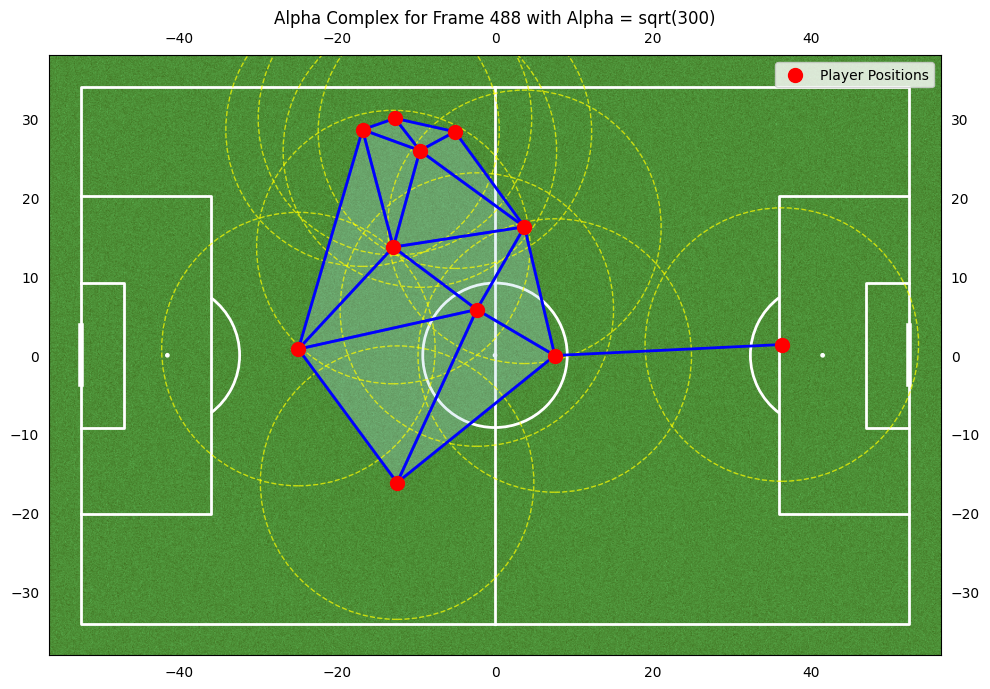

In [19]:

# Apply alpha complex and plot for a specific frame with circles
alpha_complex_on_frame(df[::48], regex="^home", frame_idx=frame_idx, max_alpha_square=300)


Average Wasserstein distance between frame 100 and frame 150: 5.926156463948163


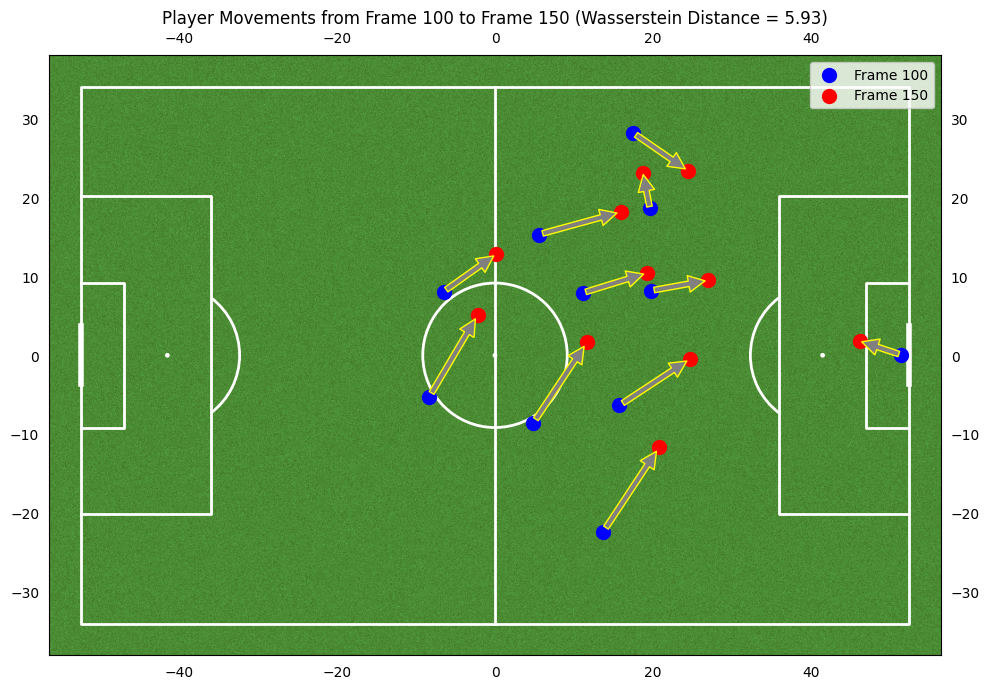

In [15]:
import numpy as np
from scipy.stats import wasserstein_distance
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Example function to get player positions from the DataFrame
def get_player_positions(df, frame_idx, regex="^home"):
    return df.iloc[frame_idx].filter(regex=regex).dropna().values.reshape(-1, 2)

# Assume df is your DataFrame containing player positions
positions_frame_100 = get_player_positions(df, frame_idx=50, regex="^home")
positions_frame_150 = get_player_positions(df, frame_idx=150, regex="^home")

# Calculate Wasserstein distance between each corresponding player's position
distances = []
for i in range(len(positions_frame_100)):
    distance = wasserstein_distance(positions_frame_100[i], positions_frame_150[i])
    distances.append(distance)

# Average distance gives you an idea of how much the formation has changed
average_wasserstein_distance = np.mean(distances)
print(f"Average Wasserstein distance between frame 100 and frame 150: {average_wasserstein_distance}")

# Now let's visualize the player positions for both frames on the same pitch
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# Plot player positions for frame 100 (blue) and frame 150 (red)
ax.scatter(positions_frame_100[:, 0], positions_frame_100[:, 1], color='blue', s=100, zorder=3, label="Frame 100")
ax.scatter(positions_frame_150[:, 0], positions_frame_150[:, 1], color='red', s=100, zorder=3, label="Frame 150")

# Add vectors (arrows) to indicate movement between the two frames
for i in range(len(positions_frame_100)):
    ax.annotate('', xy=(positions_frame_150[i][0], positions_frame_150[i][1]), 
                xytext=(positions_frame_100[i][0], positions_frame_100[i][1]),
                arrowprops=dict(facecolor='gray', edgecolor='yellow', shrink=0.05))

plt.legend()
plt.title(f"Player Movements from Frame 100 to Frame 150 (Wasserstein Distance = {average_wasserstein_distance:.2f})")
plt.show()


In [16]:
def compute_team_wasserstein_distance(df, frame_idx, home_regex="^home", away_regex="^away"):
    home_positions = get_player_positions(df, frame_idx, home_regex)
    away_positions = get_player_positions(df, frame_idx, away_regex)

    # Flatten the positions to compare the whole distribution
    flat_home_positions = home_positions.flatten()
    flat_away_positions = away_positions.flatten()

    # Compute the Wasserstein distance between the two teams' positions
    distance = wasserstein_distance(flat_home_positions, flat_away_positions)
    return distance

# Compare formations of home and away teams at frame 100
team_distance = compute_team_wasserstein_distance(df, frame_idx=100)
print(f"Wasserstein distance between home and away teams at frame 100: {team_distance}")


Wasserstein distance between home and away teams at frame 100: 9.560771240768107


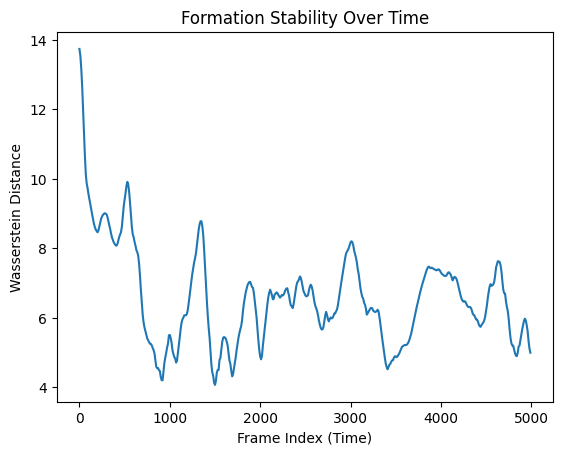

In [17]:
# Calculate distances between consecutive frames over a range of frames
frame_indices = list(range(0, 5000, 10))  # Example frames every 10 seconds
distances_over_time = [
    compute_team_wasserstein_distance(df, frame_idx=i) for i in frame_indices
]

# Plot the distances over time
import matplotlib.pyplot as plt

plt.plot(frame_indices, distances_over_time)
plt.xlabel('Frame Index (Time)')
plt.ylabel('Wasserstein Distance')
plt.title('Formation Stability Over Time')
plt.show()
